In [1]:
import loompy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata

import scipy

In [2]:
import sys

import scipy.stats as st

In [1]:
import os

os.system("wget --quiet https://storage.googleapis.com/linnarsson-lab-loom/dev_all.loom")

2

In [3]:
ds = loompy.connect("dev_all.loom")

In [4]:
ds.shape

(31053, 292495)

In [5]:
ds.ra.keys()

['Accession',
 'Chromosome',
 'End',
 'Gamma',
 'Gene',
 'HPF',
 'HPF_beta',
 'MultilevelMarkers',
 'Selected',
 'Start',
 'Strand',
 'Valid']

In [6]:
ds.ca.keys()

['Age',
 'BTSNE',
 'CellCycle',
 'CellID',
 'Cell_Conc',
 'Chemistry',
 'ChipID',
 'Class',
 'ClusterName',
 'Clusters',
 'Date_Captured',
 'DonorID',
 'DoubletFinderPCA',
 'HPF',
 'HPF_LogPP',
 'HPF_theta',
 'IsCycling',
 'Label',
 'Location_E9_E11',
 'NCellsCluster',
 'NGenes',
 'Num_Pooled_Animals',
 'PCA',
 'PCR_Cycles',
 'Plug_Date',
 'Project',
 'PseudoAge',
 'PseudoTissue',
 'Region',
 'SampleID',
 'SampleName',
 'Sample_Index',
 'Sex',
 'Species',
 'Split',
 'Strain',
 'Subclass',
 'TSNE',
 'Target_Num_Cells',
 'Tissue',
 'TotalUMI',
 'Transcriptome',
 'UMAP',
 'UMAP3D',
 'cDNA_Lib_Ok',
 'ngperul_cDNA']

In [7]:
type(ds)

loompy.loompy.LoomConnection

In [11]:
ds.ca.Age

array(['e7.0', 'e7.0', 'e7.0', ..., 'e16.0', 'e17.0', 'e17.0'],
      dtype=object)

In [12]:
#ClusterName

meta = pd.DataFrame()
meta['Age'] = ds.ca.Age
meta['ClusterName'] = ds.ca.ClusterName

meta.head()

Age ClusterName
0  e7.0     ParEndo
1  e7.0     ParEndo
2  e7.0     ParEndo
3  e7.0     ParEndo
4  e7.0     ParEndo

In [14]:
meta.to_csv('metadata.csv')

In [13]:
adata = anndata.read_loom("dev_all.loom")

In [ ]:
adata

In [ ]:
adata.obs

In [11]:
# Parameter settings we use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 30
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 2

mito_criteria = 5

n_top_genes = 2000

n_bins = 20

flavor="seurat"

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [13]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

# mito_genes = adata.var_names.str.startswith('mt-')
# adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

In [ ]:
# adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
# adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
# adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [ ]:
# cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
# gene_mask = adata.var["pass_gene_filter"].values

In [ ]:
# print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
# print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

In [14]:
data = adata #[cell_mask, gene_mask]

In [15]:
data.layers["raw"] = data.X

In [16]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [17]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [18]:
data.X = data.layers["log1p"]

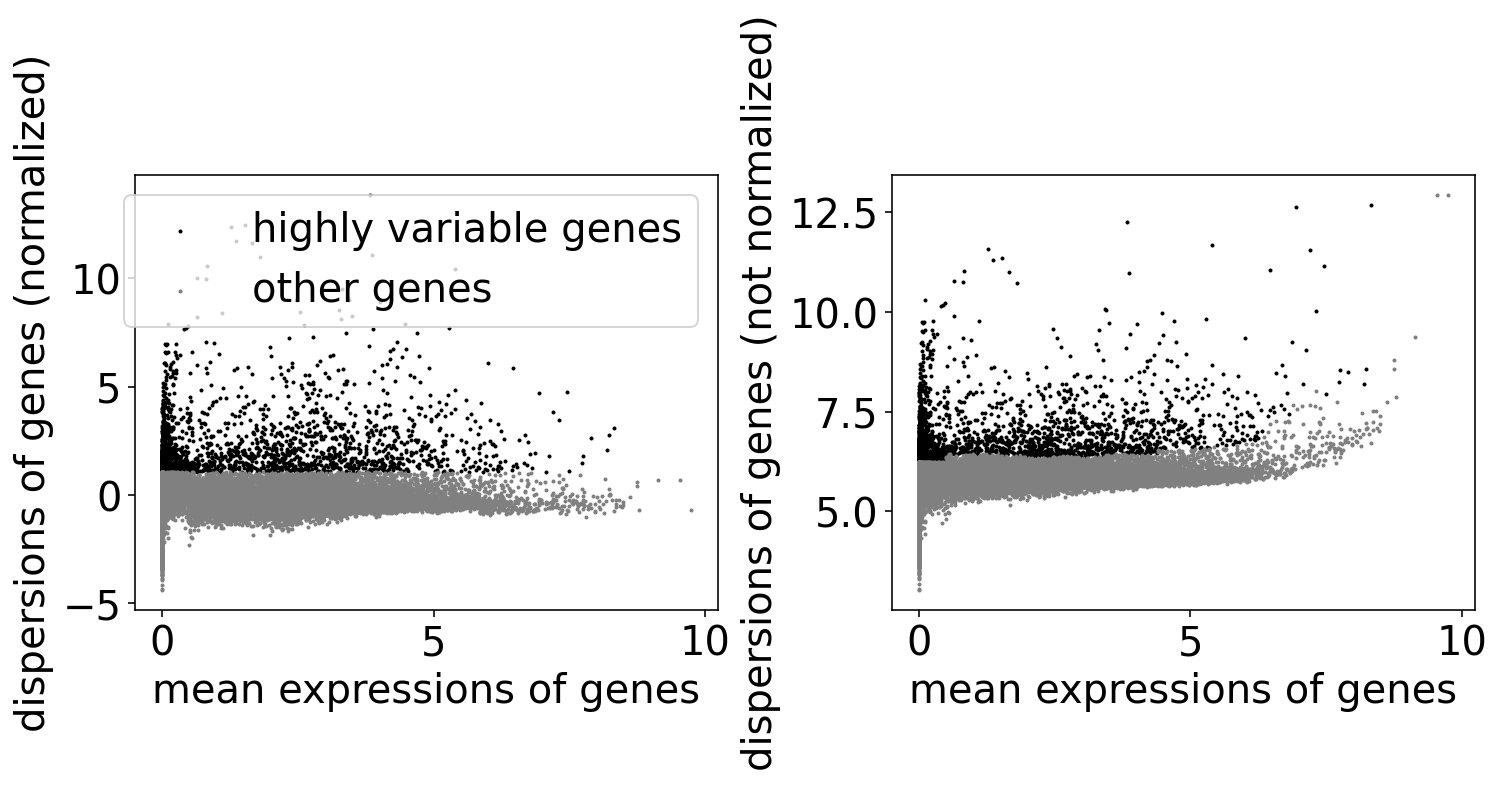

In [19]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values
sc.pl.highly_variable_genes(data)

In [ ]:
# %%time
# # Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
# mat = data.layers["log1p"].toarray()
# data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
# data.X = data.layers["scale"]

# del mat

In [20]:
hvg_data = data[:, hvg_mask]

In [ ]:
np.save("gene_names.npy", hvg_mask)

In [21]:
scipy.io.mmwrite('dev_all_raw.mtx', hvg_data.layers['raw'])

In [22]:
scipy.io.mmwrite('dev_all_hvg.mtx', hvg_data.layers['log1p'])

In [ ]:
# nc.PCA_analysis(hvg_data, ndims = 30)

In [25]:
hvg_data

AnnData object with n_obs × n_vars = 153847 × 1999
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'Cla

In [27]:
# %%time
# X = hvg_data.obsm['X_PCA_30']
# lab1 = list(hvg_data.obs['ClusterName'])
# allLabs = np.array([lab1])
# nca = NN_NCA(n_latent = 10, epochs = 50)

# latent = nca.fit(X,allLabs,batch_size = 400,fracNCA = 0.9, silent = True)
# tsne = vis.tSNE(hvg_data, 'type_tsne', latent, ndims = 2, state = state)
# hvg_data.obsm["X_nnNCA"] = latent

(153847, 30) 153847
CPU times: user 15h 12min 2s, sys: 10h 12min, total: 1d 1h 24min 2s
Wall time: 41min 53s
